# Analyze motion data from SenseHAT to detect figures

With the TjBot based on Raspberry Pi the motion sensor data (acc, gyro, compass, ..) from the SenseHAT will be pushed through the IoT Foundation via MQTT into a cloudant DB. With this python notebook you will be able to collect this data and create some visualisations.

With this python notebook you will be able to 

* collect this data and create some visualisations
* and to train a support vector classifier

## Install the necessary python libraries missing by default

In [1]:
# install missing library for cloudant
!pip install cloudant

Requirement not upgraded as not directly required: cloudant in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: requests<3.0.0,>=2.7.0 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from cloudant)
Requirement not upgraded as not directly required: chardet<3.1.0,>=3.0.2 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)
Requirement not upgraded as not directly required: idna<2.7,>=2.5 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)
Requirement not upgraded as not directly required: urllib3<1.23,>=1.21.1 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)
Requirement not upgraded as not directly required: certifi>=2017.4.17 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from requests<3.0.0,>=2.7.0->cloudant)


## Get the credentials to access the cloudant DB

Use the existing connection document (CloudandDB) and push "insert code" rename it to credentials.

In [2]:
# The code was removed by Watson Studio for sharing.

## Import the cloudant client 

In [3]:
from cloudant.client import Cloudant
from cloudant.result import Result, ResultByKey
from cloudant.query import Query

client = Cloudant(credentials['username'], credentials['password'], 
                  url=credentials['custom_url'], connect=True)

### Select the database

In [4]:
database  = client['sensehat_motion']

## Construct a Query for Motion objects

maybe query as a sorted list but needs index in the DB: 
    sort=['payload.d.device', 'payload.d.userid','payload.d.figure','payload.d.motionset', 'payload.d.date']

In [5]:
# Select statement for document selection
# filter on one the date element to collect the subset
selector = {
    '_id':{'$gt': 0},
    'payload.d.motionset': {
        '$gte': '2018-12-16T08:00',  # $gte: greater than or equal
        '$lt': '2018-12-17T00:00'},  # $lte: less than or equal
}

# Selected fields of the document
fields = [
    'payload.d.acceleration',
    'payload.d.gyroscope',
    'payload.d.orientation',
    'payload.d.compass',
    'payload.d.device',    
    'payload.d.userid',
    'payload.d.figure',
    'payload.d.motionset',
    'payload.d.timestamp',
    'payload.d.date']

# Create the query and get a handler
motion_query = Query (
    database,
    selector=selector, 
    fields=fields
)

In [6]:
# show 5 elements from the cloudantDB
for doc in motion_query(limit=5) ['docs']:
    print(doc)

{'payload': {'d': {'gyroscope': {'y': 0.1701, 'x': 0.7205, 'z': -0.4047}, 'device': 'tjbot-01', 'timestamp': 1544952173255, 'orientation': {'yaw': 266.6693, 'pitch': 272.4581, 'roll': 174.0104}, 'compass': 267, 'acceleration': {'y': 0.1088, 'x': 0.7043, 'z': 0.0502}, 'figure': '0', 'userid': 25, 'date': '2018-12-16T09:22:53.255Z', 'motionset': '2018-12-16T09:22:52.975Z'}}}
{'payload': {'d': {'gyroscope': {'y': 0.8891, 'x': 0.2755, 'z': -0.314}, 'device': 'tjbot-01', 'timestamp': 1544952173443, 'orientation': {'yaw': 29.3036, 'pitch': 273.9562, 'roll': 55.4462}, 'compass': 29, 'acceleration': {'y': -0.2957, 'x': 0.6723, 'z': 0.115}, 'figure': '0', 'userid': 25, 'date': '2018-12-16T09:22:53.443Z', 'motionset': '2018-12-16T09:22:52.975Z'}}}
{'payload': {'d': {'gyroscope': {'y': -1.0367, 'x': -1.1245, 'z': -0.298}, 'device': 'tjbot-01', 'timestamp': 1544952176662, 'orientation': {'yaw': 52.4886, 'pitch': 290.1022, 'roll': 9.9968}, 'compass': 52, 'acceleration': {'y': 0.53, 'x': 1.315, 'z':

# Using pandas for the data processing

In [7]:
import pandas as pd
from pandas import date_range, to_datetime
from pandas.io.json import json_normalize
from pandas import Timestamp, DataFrame, Series, Timedelta, concat

## Store the data in an array as a table

Also rename the columns for better reading afterwards

In [8]:
# get all json-objects (documents) out of the query 
json_docs = motion_query()['docs']

# normalize into a dataframe
df = json_normalize(json_docs)

df.head()

,payload.d.acceleration.x,payload.d.acceleration.y,payload.d.acceleration.z,payload.d.compass,payload.d.date,payload.d.device,payload.d.figure,payload.d.gyroscope.x,payload.d.gyroscope.y,payload.d.gyroscope.z,payload.d.motionset,payload.d.orientation.pitch,payload.d.orientation.roll,payload.d.orientation.yaw,payload.d.timestamp,payload.d.userid
0,0.7043,0.1088,0.0502,267,2018-12-16T09:22:53.255Z,tjbot-01,0,0.7205,0.1701,-0.4047,2018-12-16T09:22:52.975Z,272.4581,174.0104,266.6693,1544952173255,25
1,0.6723,-0.2957,0.1150,29,2018-12-16T09:22:53.443Z,tjbot-01,0,0.2755,0.8891,-0.3140,2018-12-16T09:22:52.975Z,273.9562,55.4462,29.3036,1544952173443,25
2,1.3150,0.5300,0.4328,52,2018-12-16T09:22:56.662Z,tjbot-01,0,-1.1245,-1.0367,-0.2980,2018-12-16T09:22:55.812Z,290.1022,9.9968,52.4886,1544952176662,25
3,0.9809,0.2515,-0.0070,220,2018-12-16T09:22:58.467Z,tjbot-01,0,-0.0552,-0.2979,-0.1300,2018-12-16T09:22:58.288Z,271.7811,214.2620,219.6281,1544952178467,25
4,1.5662,0.0422,0.5878,64,2018-12-16T09:22:59.037Z,tjbot-01,0,-1.2959,0.5308,-0.7787,2018-12-16T09:22:58.288Z,293.3238,12.7595,64.0027,1544952179037,25


In [9]:
# rename all columns into clear names
df = df.rename(
    columns= {
    'payload.d.acceleration.x' : 'acc_x',
    'payload.d.acceleration.y' : 'acc_y',
    'payload.d.acceleration.z' : 'acc_z',
    'payload.d.gyroscope.x' : 'gyro_x',
    'payload.d.gyroscope.y' : 'gyro_y',
    'payload.d.gyroscope.z' : 'gyro_z',
    'payload.d.orientation.roll' : 'roll',
    'payload.d.orientation.pitch' : 'pitch',
    'payload.d.orientation.yaw' : 'yaw',
    'payload.d.compass':'compass',
    'payload.d.device':'device',    
    'payload.d.userid':'userid',
    'payload.d.figure':'figure',
    'payload.d.motionset':'motionset',
    'payload.d.timestamp':'timestamp',
    'payload.d.date':'date'        
    }
)
df.head()

,acc_x,acc_y,acc_z,compass,date,device,figure,gyro_x,gyro_y,gyro_z,motionset,pitch,roll,yaw,timestamp,userid
0,0.7043,0.1088,0.0502,267,2018-12-16T09:22:53.255Z,tjbot-01,0,0.7205,0.1701,-0.4047,2018-12-16T09:22:52.975Z,272.4581,174.0104,266.6693,1544952173255,25
1,0.6723,-0.2957,0.1150,29,2018-12-16T09:22:53.443Z,tjbot-01,0,0.2755,0.8891,-0.3140,2018-12-16T09:22:52.975Z,273.9562,55.4462,29.3036,1544952173443,25
2,1.3150,0.5300,0.4328,52,2018-12-16T09:22:56.662Z,tjbot-01,0,-1.1245,-1.0367,-0.2980,2018-12-16T09:22:55.812Z,290.1022,9.9968,52.4886,1544952176662,25
3,0.9809,0.2515,-0.0070,220,2018-12-16T09:22:58.467Z,tjbot-01,0,-0.0552,-0.2979,-0.1300,2018-12-16T09:22:58.288Z,271.7811,214.2620,219.6281,1544952178467,25
4,1.5662,0.0422,0.5878,64,2018-12-16T09:22:59.037Z,tjbot-01,0,-1.2959,0.5308,-0.7787,2018-12-16T09:22:58.288Z,293.3238,12.7595,64.0027,1544952179037,25


## Reorganize the array and sort

In [10]:
# get the columns names
cols = df.columns.tolist()
cols

['acc_x',
 'acc_y',
 'acc_z',
 'compass',
 'date',
 'device',
 'figure',
 'gyro_x',
 'gyro_y',
 'gyro_z',
 'motionset',
 'pitch',
 'roll',
 'yaw',
 'timestamp',
 'userid']

In [11]:
# reorder the columns from the array
cols = [
    'device',
    'userid',    
    'figure',
    'motionset',
    'date',
    'timestamp',
    'acc_x',
    'acc_y',
    'acc_z',
    'gyro_x',
    'gyro_y',
    'gyro_z',
    'pitch',
    'roll',
    'yaw',
    'compass'
]

df = df[cols]
df.head()

,device,userid,figure,motionset,date,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pitch,roll,yaw,compass
0,tjbot-01,25,0,2018-12-16T09:22:52.975Z,2018-12-16T09:22:53.255Z,1544952173255,0.7043,0.1088,0.0502,0.7205,0.1701,-0.4047,272.4581,174.0104,266.6693,267
1,tjbot-01,25,0,2018-12-16T09:22:52.975Z,2018-12-16T09:22:53.443Z,1544952173443,0.6723,-0.2957,0.1150,0.2755,0.8891,-0.3140,273.9562,55.4462,29.3036,29
2,tjbot-01,25,0,2018-12-16T09:22:55.812Z,2018-12-16T09:22:56.662Z,1544952176662,1.3150,0.5300,0.4328,-1.1245,-1.0367,-0.2980,290.1022,9.9968,52.4886,52
3,tjbot-01,25,0,2018-12-16T09:22:58.288Z,2018-12-16T09:22:58.467Z,1544952178467,0.9809,0.2515,-0.0070,-0.0552,-0.2979,-0.1300,271.7811,214.2620,219.6281,220
4,tjbot-01,25,0,2018-12-16T09:22:58.288Z,2018-12-16T09:22:59.037Z,1544952179037,1.5662,0.0422,0.5878,-1.2959,0.5308,-0.7787,293.3238,12.7595,64.0027,64


### change the values to its datatype and sort the values 

In [12]:
df['date'] = to_datetime(df.date)
df['motionset'] = to_datetime(df.motionset)
df['figure'] = [str(l) for l in df.figure]
df = df.set_index('date').sort_index()
df = df.sort_values(['device','userid','figure','motionset'])
df.head()

,device,userid,figure,motionset,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pitch,roll,yaw,compass
date,,,,,,,,,,,,,,,
2018-12-16 09:22:38.899,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952158899,0.6585,0.0311,0.7467,0.0189,0.0772,-0.0061,318.5956,2.0408,100.1981,100
2018-12-16 09:22:38.995,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952158995,0.6512,0.0204,0.7438,0.0124,-0.0126,0.0187,318.6558,2.0639,100.2466,100
2018-12-16 09:22:39.087,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952159087,0.6490,0.0211,0.7447,-0.0092,0.0213,0.0040,318.6254,2.0542,100.2839,100
2018-12-16 09:22:39.183,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952159183,0.6612,0.0320,0.7479,0.0134,-0.0098,-0.0064,318.6935,1.9842,100.3140,100
2018-12-16 09:22:39.279,tjbot-01,25,0,2018-12-16 09:22:33.708,1544952159279,0.6490,0.0187,0.7491,0.0085,0.0103,0.0141,318.7601,2.0613,100.3102,100


In [13]:
# show the end of the dataframe
df.tail()

,device,userid,figure,motionset,timestamp,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,pitch,roll,yaw,compass
date,,,,,,,,,,,,,,,
2018-12-16 13:45:12.461,tjbot-02,50,9,2018-12-16 13:45:11.608,1544967912461,0.9812,-0.5551,0.1102,-0.6788,1.1000,0.1973,275.8146,237.5804,203.0495,203
2018-12-16 13:45:12.557,tjbot-02,50,9,2018-12-16 13:45:11.608,1544967912557,1.0908,-0.1346,0.2376,-0.5664,0.9476,-0.4581,276.6166,297.1042,137.8516,138
2018-12-16 13:45:12.649,tjbot-02,50,9,2018-12-16 13:45:11.608,1544967912649,1.2168,0.1605,0.2644,-0.7643,0.7668,-0.3140,279.0975,331.5956,98.3985,98
2018-12-16 13:45:12.745,tjbot-02,50,9,2018-12-16 13:45:11.608,1544967912745,1.3228,0.2680,0.2600,-0.4760,0.4045,-0.1823,281.4407,345.7506,81.9578,82
2018-12-16 13:45:12.842,tjbot-02,50,9,2018-12-16 13:45:11.608,1544967912842,1.0966,0.1066,0.3741,-0.0392,0.6990,0.0559,284.8697,351.1734,75.5250,76


# Organize all figures out of the training set into an directory

In [14]:
from collections import defaultdict

## store figures & motions into a directory 

create a loop of all figures and store each motionset into a dataframe (appand into an array on each figure)

In [15]:
# loop only for 5 motionsets for demonstration only
for (figure, motionset_id), motionset_data in list(df.groupby(['figure', 'motionset']))[:5]:
    print(figure, motionset_id, len(motionset_data), type(motionset_data))

0 2018-12-16 09:22:33.708000 16 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:49.694000 15 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:52.975000 15 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:55.812000 15 <class 'pandas.core.frame.DataFrame'>
0 2018-12-16 09:22:58.288000 15 <class 'pandas.core.frame.DataFrame'>


### Usage of special directories

In [16]:
# classical directories give a failure if the element doesn't exist
d={}
# d['a']

In [17]:
# special directory which allows asking elements without failure when not exists
d = defaultdict(list)
d['a']

[]

### store all motions into motionset

motionset will be the overall array of every figures

In [18]:
# using groupby function on the motions dataset
motionset = defaultdict(list)
for (figure, _), data in df.groupby(['figure', 'motionset']):
    motionset[figure].append(data)

# give the amount of each figure and its stored motions
for figure, datasets in sorted(motionset.items()):
    print ("'{}' : {} recorded motions".format(figure, len(datasets)))

'0' : 27 recorded motions
'1' : 15 recorded motions
'2' : 15 recorded motions
'3' : 21 recorded motions
'4' : 19 recorded motions
'5' : 15 recorded motions
'6' : 38 recorded motions
'7' : 16 recorded motions
'8' : 22 recorded motions
'9' : 23 recorded motions


# Plot examples to gain insights of the motionsets

In [19]:
import matplotlib.pyplot as plt

## Sample of one figure

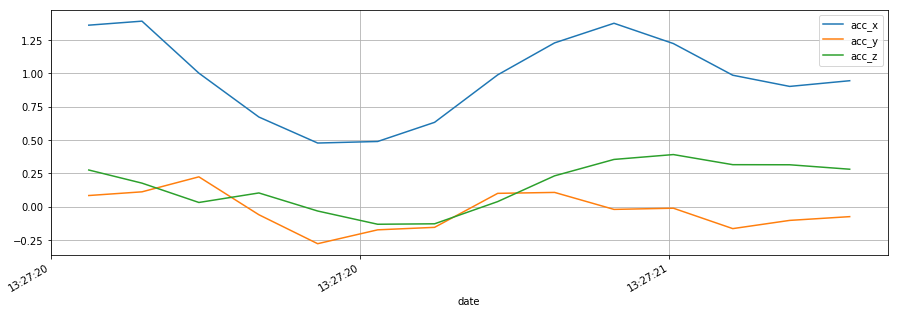

In [20]:
# first array is the figure, second is one motionset 
motionset['1'][-1][['acc_x', 'acc_y', 'acc_z']].plot(grid=True, figsize=(15,5))

### Sample Plot on each figure

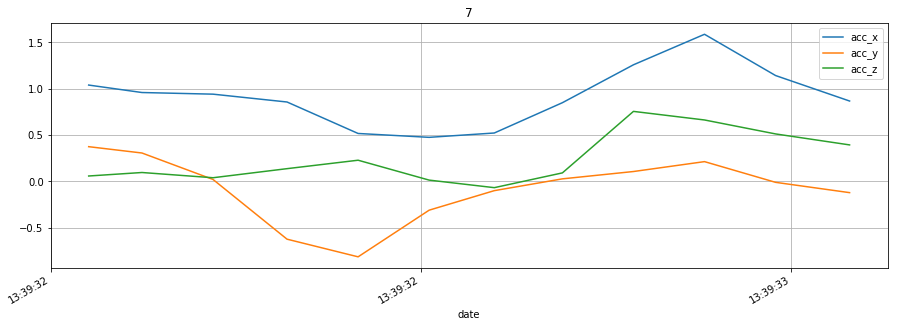

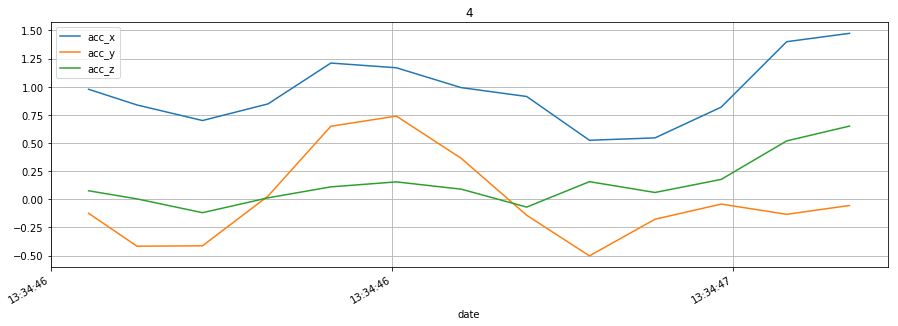

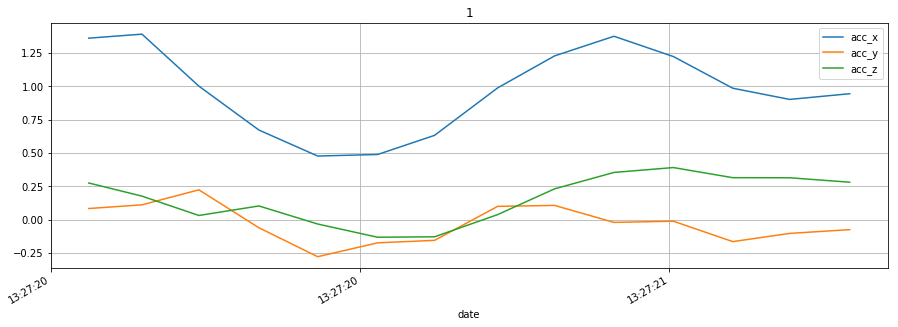

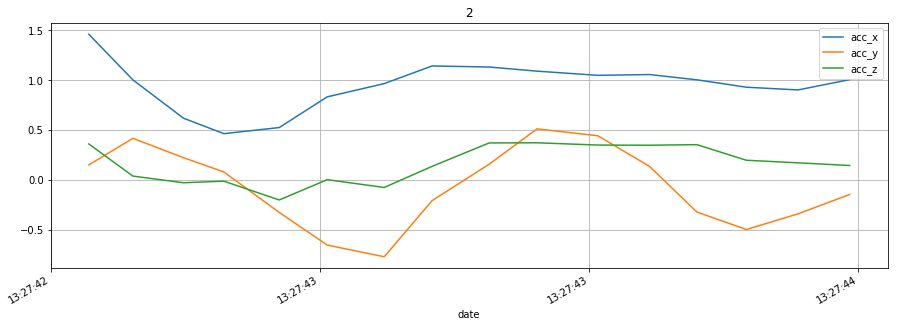

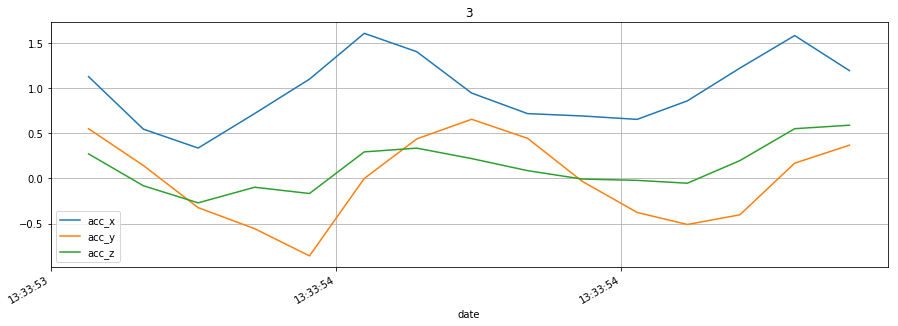

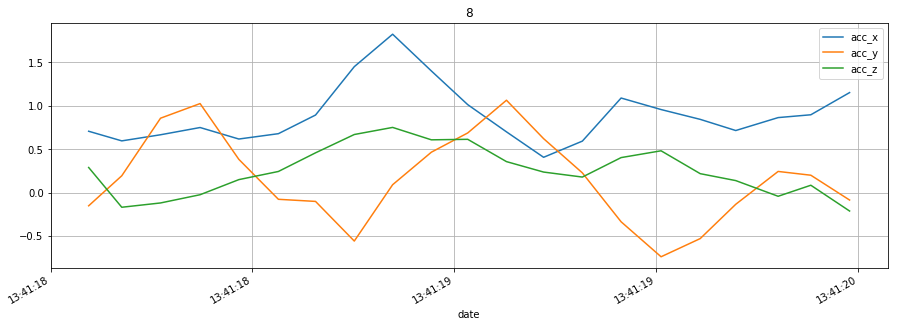

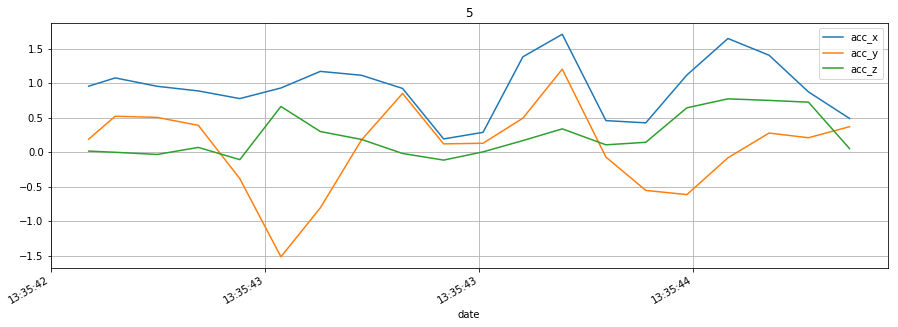

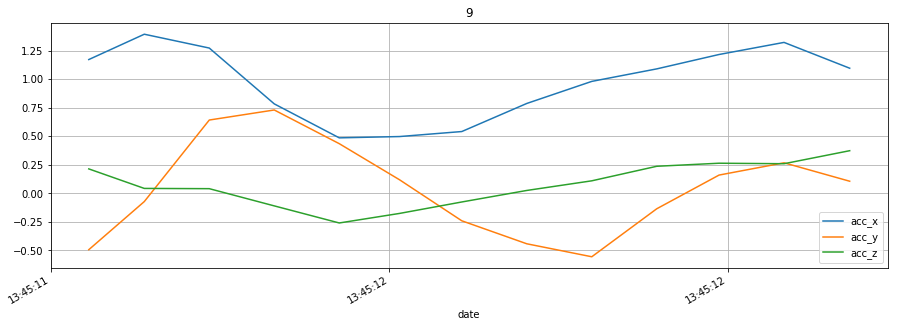

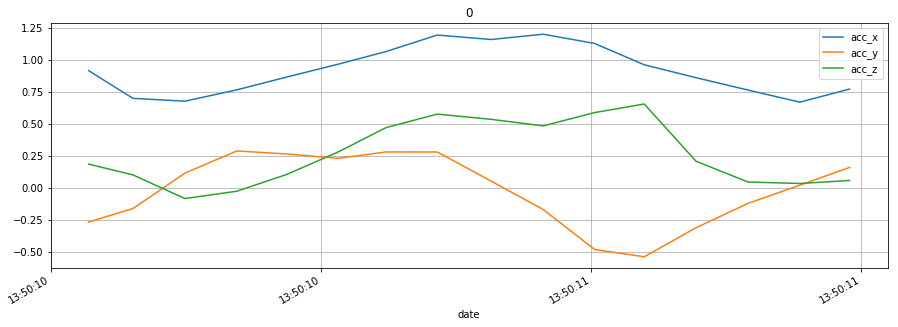

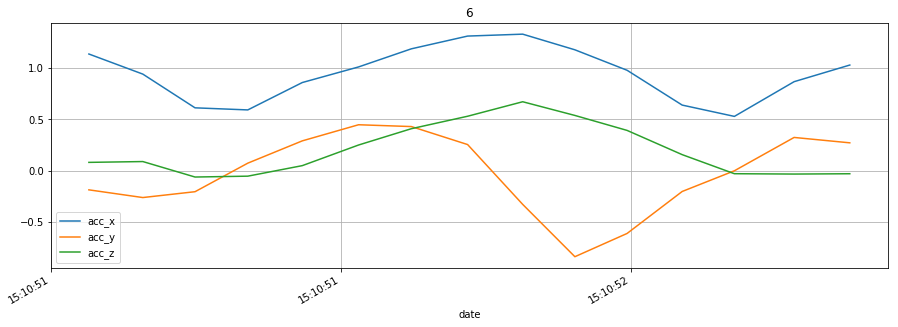

In [21]:
# get all figures and plot one figure (the last motion for each figure: -1)
for k in motionset.keys():
    motionset[k][-1][['acc_x', 'acc_y', 'acc_z']].plot(title=k, grid=True, figsize=(15,5))

### Sample Plot on each figure multiple motionsets

to get insights into the difference of each motionset on the same figure

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/matplotlib/pyplot.py:523: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


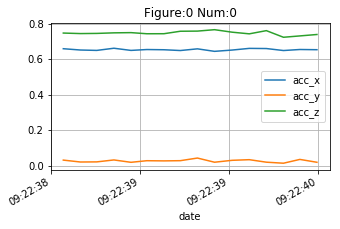

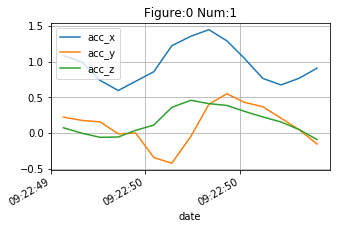

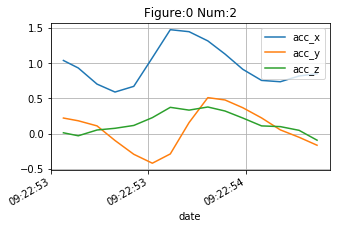

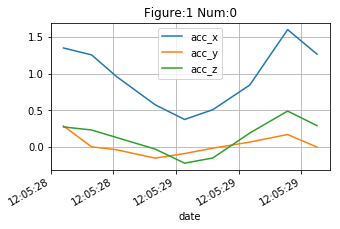

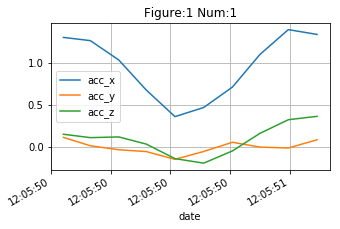

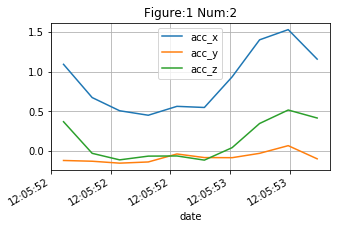

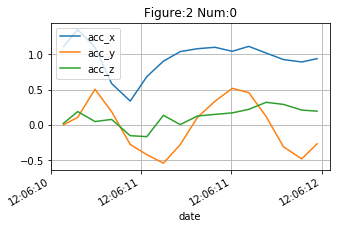

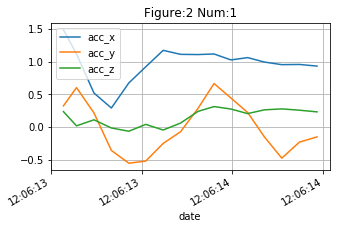

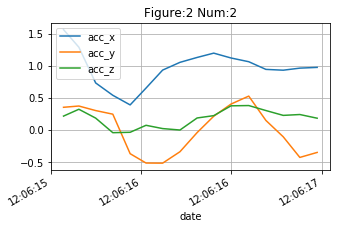

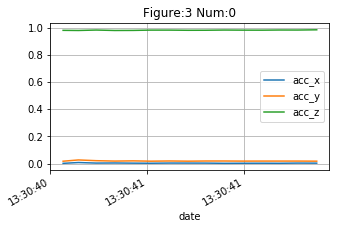

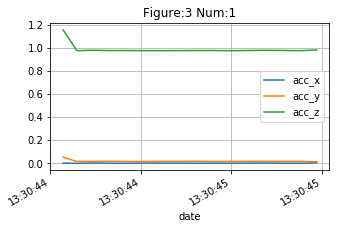

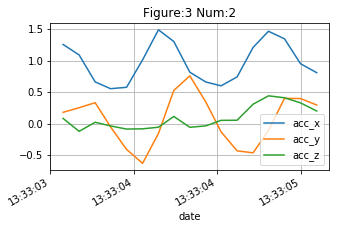

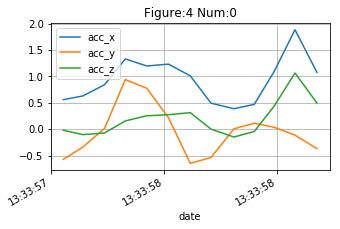

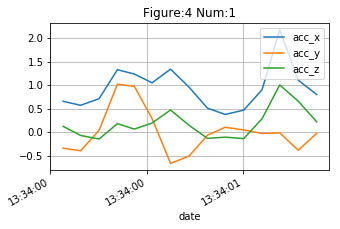

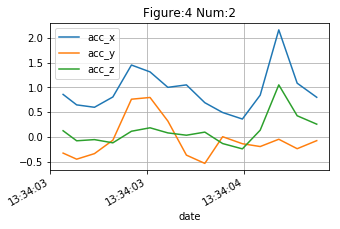

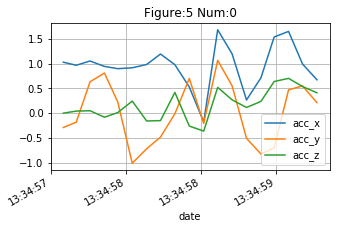

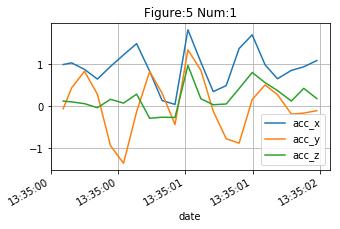

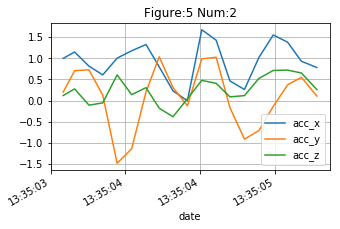

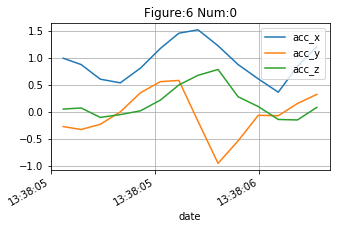

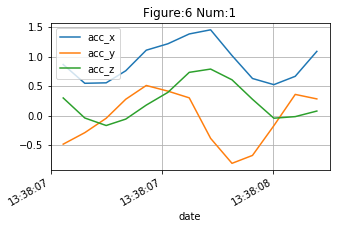

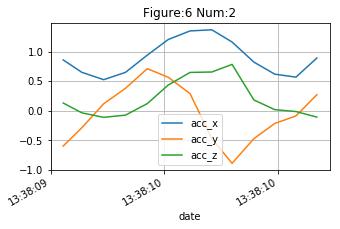

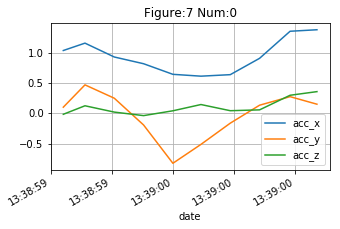

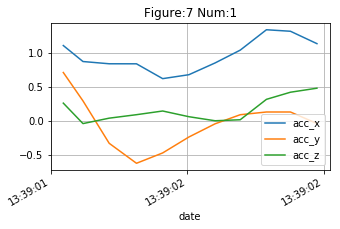

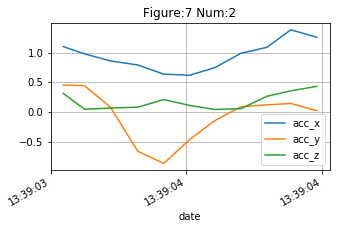

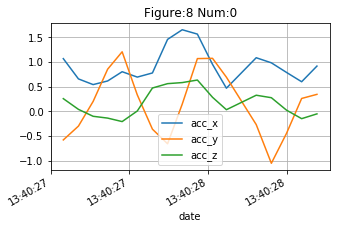

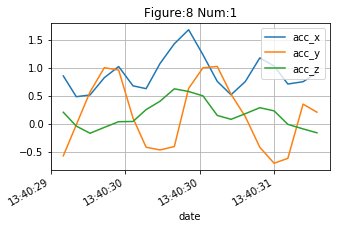

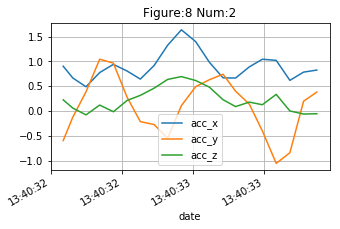

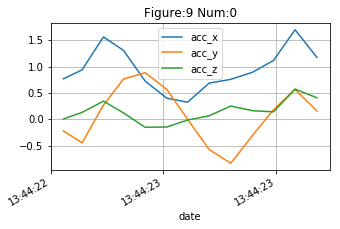

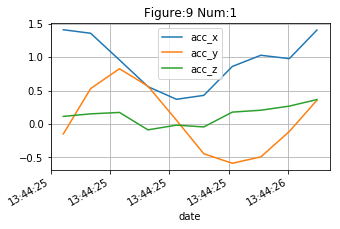

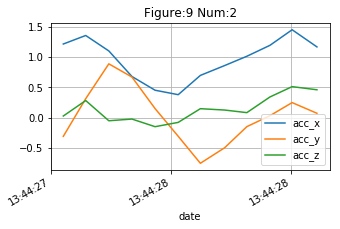

In [22]:
#  print up to 3 on one figure to compare its behavior
# get all the possible figures
for fig in sorted(motionset.keys()):

    # max 3 plots
    l = len(motionset[fig])
    if l > 3:
        l = 3

    # print max l on each figure
    for i in range(l):
        motionset[fig][i][['acc_x', 'acc_y', 'acc_z']].plot(title='Figure:' + fig + ' Num:' + str(i), grid=True, figsize=(5,3))


Total:10 Rows: 5 Cols:2


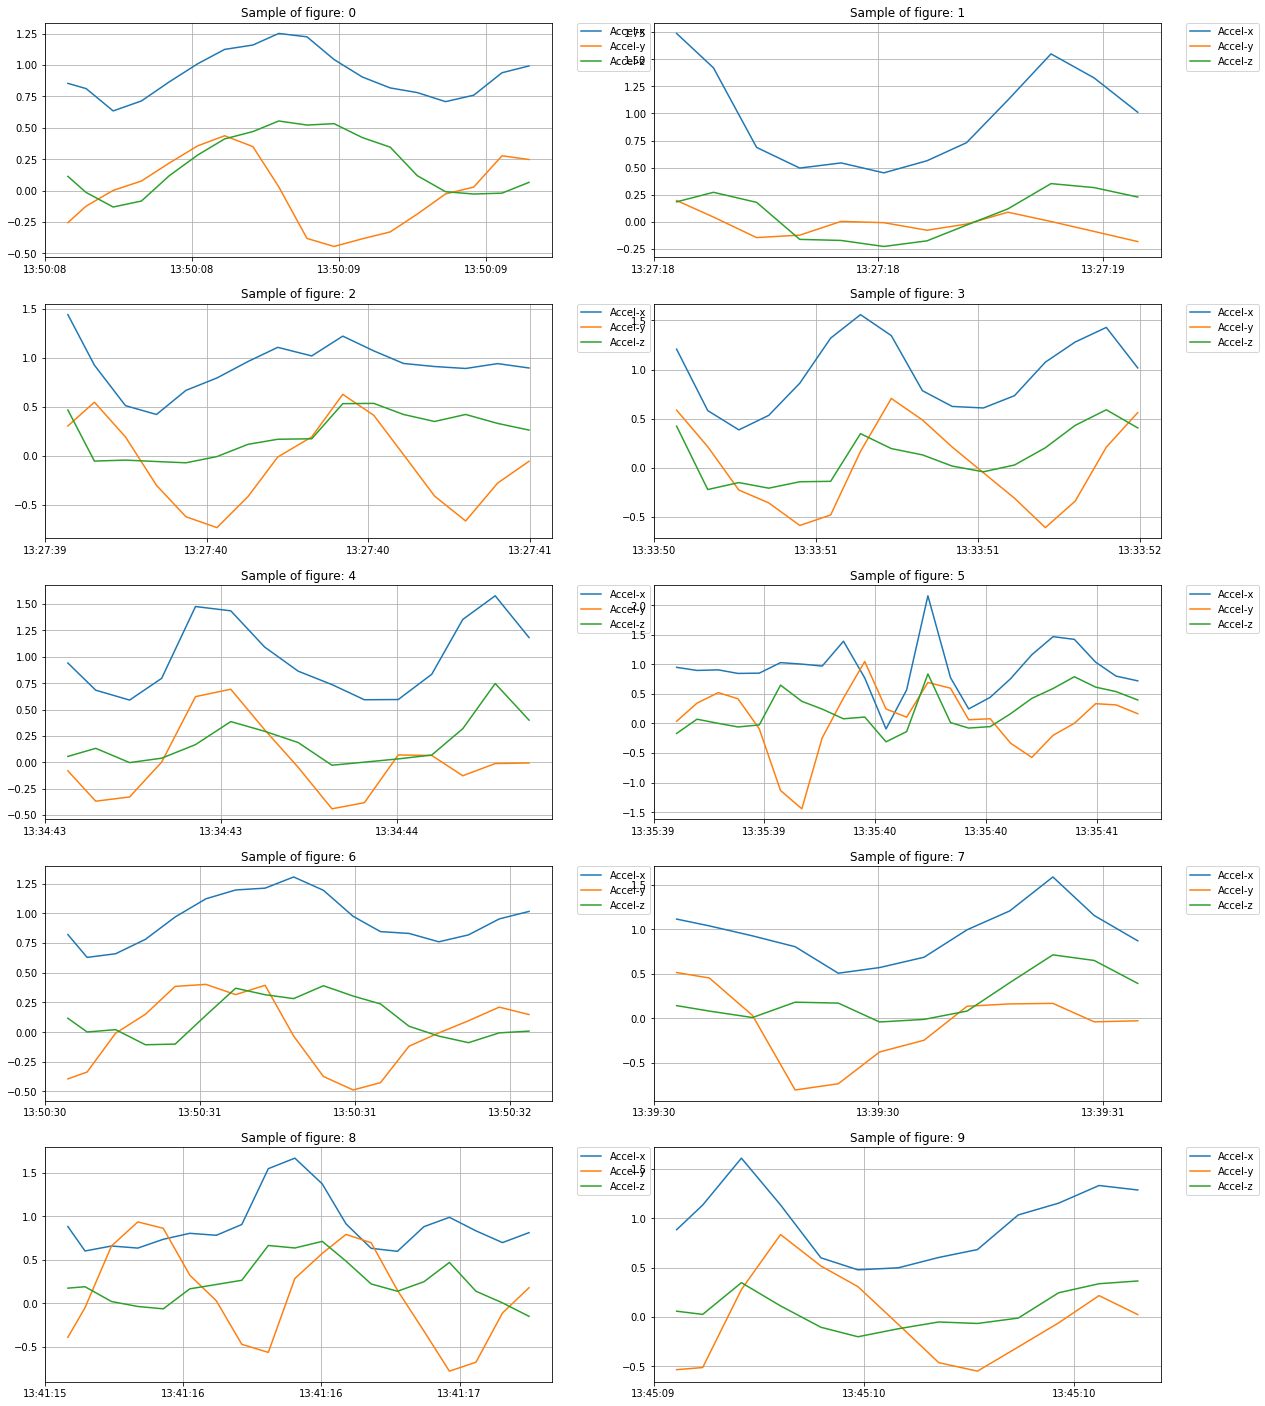

In [23]:
# Subplots are organized in a Rows x Cols Grid
figures = sorted(motionset.keys())
Tot = len(figures)
Cols = 2

# Compute Rows required
Rows = Tot // Cols 
Rows += Tot % Cols

print('Total:' + str(Tot) + ' Rows: ' + str(Rows) + ' Cols:' + str(Cols))

# Create a Position index
Position = range(1,Tot + 1)

# Create main figure
fig = plt.figure(1)
fig.set_size_inches(20,25)

# Create a figure on each sample motionset
i = 0 
for k in figures:    
    # add every single subplot to the figure with a for loop
    ax = fig.add_subplot(Rows,Cols,Position[i])
    df = motionset[k][-2]
    ax.plot(df.index, df[['acc_x']], label='Accel-x')
    ax.plot(df.index, df[['acc_y']], label='Accel-y')
    ax.plot(df.index, df[['acc_z']], label='Accel-z')

    ax.set_title('Sample of figure: '+ k)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    ax.grid(True)
    i+=1
    
plt.show()

# Build a training data set

* The idea is to transform all figures into equally long montions.
* Then we can pass them into a classical machine learning algorithms like a support vecotor classifier.
* We will achieve this by interpolating along the time axis.
* We concentrate on the accelleration features first


In [24]:
features = ['acc_x', 'acc_y', 'acc_z']

In [25]:
df = motionset['0'][2][features + ['timestamp']]
df = df.set_index('timestamp')
df.index = df.index - df.index.min()

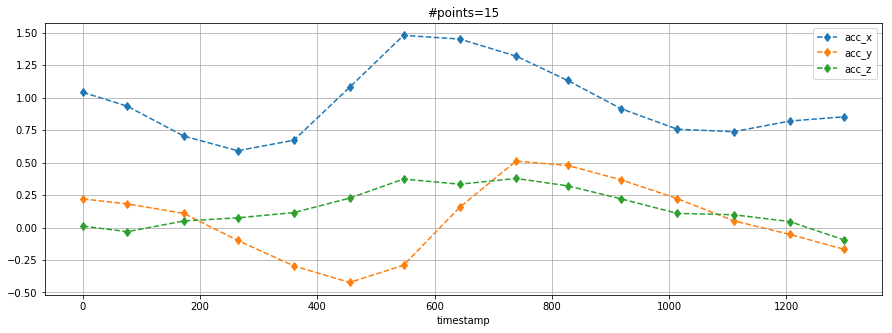

In [26]:
title="#points={:g}".format(len(df))
df.plot(style=['d--', 'd--', 'd--', ], grid=True, figsize=(15,5), title=title);

#### Make a regular time index from minimum to maximum with $n$ points

* Use numpy's linear interpolation function interp

In [27]:
import numpy as np

In [28]:
t1, t2 = df.index.min(), df.index.max()
new_index = np.linspace(t1, t2, 25)

In [29]:
np.interp(new_index, df.index, df.values[:,1])

array([ 0.2207    ,  0.19287555,  0.15720694,  0.11619375,  0.00847174,
       -0.11252075, -0.2231099 , -0.32062123, -0.39314982, -0.37740761,
       -0.29957464, -0.06768785,  0.17831875,  0.37859609,  0.50468428,
        0.48409574,  0.43155238,  0.36545729,  0.28365625,  0.19828958,
        0.10229167,  0.02375547, -0.03556719, -0.10011884, -0.1669    ])

In [30]:
ip = DataFrame(
    data = dict((col,np.interp(new_index, df.index, df[col].values)) for col in df),
    index = new_index
)
ip

,acc_x,acc_y,acc_z
0.000000,1.041100,0.220700,0.010500
54.083333,0.964956,0.192876,-0.019815
108.166667,0.857101,0.157207,-0.004524
162.250000,0.727639,0.116194,0.041841
216.333333,0.649847,0.008472,0.061958
270.416667,0.596714,-0.112521,0.077300
324.500000,0.642347,-0.223110,0.100060
378.583333,0.752032,-0.320621,0.136752
432.666667,0.984078,-0.393150,0.200058
486.750000,1.217943,-0.377408,0.276965


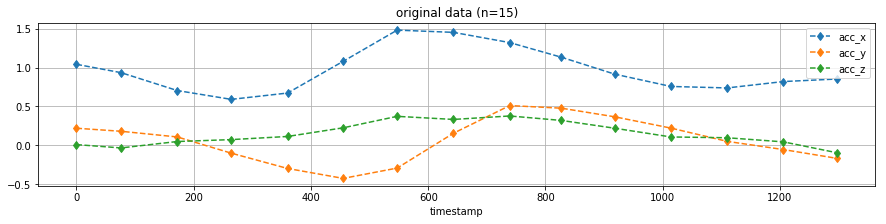

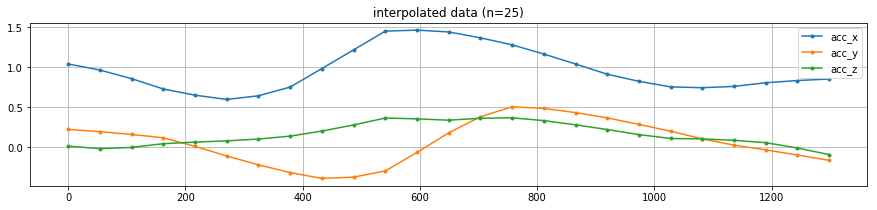

In [31]:
title="original data (n={:g})".format(len(df))
df.plot(style=['d--', 'd--', 'd--', ], grid=True, figsize=(15,3), title=title);

title="interpolated data (n={:g})".format(len(ip))
ip.plot(style=['.-', '.-', '.-', ], grid=True, figsize=(15,3), title=title);

### Combine everything into a function to make a normalized time series for each figure motion

In [32]:
def make_normalized_data(df, w=25):

    df = df.set_index('timestamp')
    df.index = (df.index - df.index.min())
    
    t1, t2 = df.index.min(), df.index.max()
    
    new_index = np.linspace(t1, t2, w)

    interp = DataFrame(
        data = dict((col, np.interp(new_index, df.index, df[col].values)) for col in df),
        index = new_index
    )
    return interp

## Data cleaning

#### Each recored motion shall have enough accelaration values

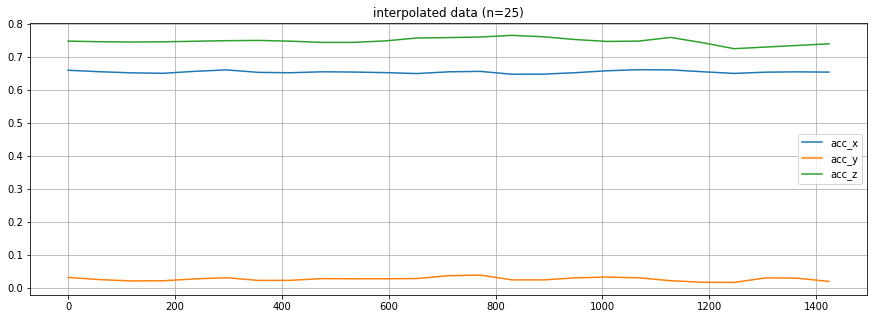

In [33]:
df = motionset['0'][0][features + ['timestamp']]
ip = make_normalized_data(df)
ip.plot(grid=True, figsize=(15,5), title=title);

In [34]:
ip.var().sum()

0.00013551082115099999

#### Each recorded motion shall have a proper duration (i.e. prober number of messages)

In [35]:
from pandas import Series
import numpy as np

# make a list of observed length
counts = [len(df) for df in motionset['1']]
print(counts)

# compute a robust estimate of the typical length
counts = Series(counts)
q25 = np.floor(counts.quantile(0.25))
q75 = np.ceil(counts.quantile(0.75))
print("quantiles:", q25, q75)

lower = q25 - 2*(q75-q25)
upper = q75 + 2*(q75-q25)
print("bounds:", lower, upper)

[9, 10, 10, 11, 12, 11, 12, 13, 12, 12, 11, 11, 10, 12, 14]
quantiles: 10.0 12.0
bounds: 6.0 16.0


#### Padas detour: A Dataframe can easily be reshape into a vector

In [36]:
ip.values

array([[ 0.6585    ,  0.0311    ,  0.7467    ],
       [ 0.65398819,  0.02448681,  0.74490764],
       [ 0.65065797,  0.02057246,  0.74402174],
       [ 0.64923913,  0.02102391,  0.74460217],
       [ 0.65526944,  0.02670139,  0.74634444],
       [ 0.65959028,  0.03024514,  0.74805833],
       [ 0.65205   ,  0.022025  ,  0.7488    ],
       [ 0.65094532,  0.02227303,  0.74659888],
       [ 0.65382917,  0.02764097,  0.74281181],
       [ 0.6530875 ,  0.02702292,  0.74293542],
       [ 0.65134493,  0.02706957,  0.7472808 ],
       [ 0.64850725,  0.02784348,  0.75624529],
       [ 0.65374271,  0.03637917,  0.75735833],
       [ 0.65510729,  0.03821215,  0.75922778],
       [ 0.64639271,  0.02368785,  0.76417222],
       [ 0.64672323,  0.02363131,  0.75986061],
       [ 0.65113056,  0.02995   ,  0.75147083],
       [ 0.65694028,  0.032175  ,  0.74572292],
       [ 0.660175  ,  0.029975  ,  0.7468    ],
       [ 0.65961875,  0.02126042,  0.757925  ],
       [ 0.65405556,  0.01658056,  0.742

In [37]:
ip.values.reshape(-1)

array([ 0.6585    ,  0.0311    ,  0.7467    ,  0.65398819,  0.02448681,
        0.74490764,  0.65065797,  0.02057246,  0.74402174,  0.64923913,
        0.02102391,  0.74460217,  0.65526944,  0.02670139,  0.74634444,
        0.65959028,  0.03024514,  0.74805833,  0.65205   ,  0.022025  ,
        0.7488    ,  0.65094532,  0.02227303,  0.74659888,  0.65382917,
        0.02764097,  0.74281181,  0.6530875 ,  0.02702292,  0.74293542,
        0.65134493,  0.02706957,  0.7472808 ,  0.64850725,  0.02784348,
        0.75624529,  0.65374271,  0.03637917,  0.75735833,  0.65510729,
        0.03821215,  0.75922778,  0.64639271,  0.02368785,  0.76417222,
        0.64672323,  0.02363131,  0.75986061,  0.65113056,  0.02995   ,
        0.75147083,  0.65694028,  0.032175  ,  0.74572292,  0.660175  ,
        0.029975  ,  0.7468    ,  0.65961875,  0.02126042,  0.757925  ,
        0.65405556,  0.01658056,  0.74216806,  0.64893043,  0.01592609,
        0.72382609,  0.65267101,  0.02972754,  0.72872754,  0.65

##### Note

The `ip.values` array is row-major. That means, that `ip.values.reshape(-1)` yields a vector where the first elements are the first *row* of `ip.values`, then the following rows are concatenated.

More general. If $A=[a_{ij}]$ for $i = 1, \ldots, m$ and $j=1, \ldots n$ and A is row-major `b = A.rehsape(-1)` will yield the vector $b = [a_{1,1}, \ldots, a_{1,n}, a_{2,1}, \ldots, a_{2,n}, \ldots, a_{m,1}, \ldots, a_{m,n}]$ 

## Build a list of relevant feature vectors and labels out of motion set

In [38]:
features = ['acc_x' ,'acc_y', 'acc_z'] # + ['gyro_x', 'gyro_y', 'gyro_z']

# vectors will contain all relevant feature vectors
vectors = []

# the corresponfing labels
labels = []

# loop over all motion sets
for figure, datasets in motionset.items():
    
    # comput robus upper and lower bounds on length
    counts = Series([len(df) for df in datasets])
    q25 = np.floor(counts.quantile(0.25))
    q75 = np.ceil(counts.quantile(0.75))
    lower = q25 - 2*(q75-q25)
    upper = q75 + 2*(q75-q25)
    
    # for each data set ...
    for df in datasets:
        # ... check its length
        if lower <= len(df) <= upper:
            # if long enough compute its normalized version
            ip = make_normalized_data(df[features + ['timestamp']])
            
            # if it has sufficient variance add it as a training example
            variance =  ip.var().sum()
            if variance > 0.01:
                vectors.append(ip.values.reshape(-1))
                labels.append(figure)
            else:
                print("Skipping motion for '{}': total variance {} to small.".format(figure, variance))
        else:
            print("Skipping motion for '{}': length {} not in range [{}, {}]".format(figure, len(df), lower, upper))

Skipping motion for '2': length 44 not in range [13.0, 18.0]
Skipping motion for '2': length 26 not in range [13.0, 18.0]
Skipping motion for '2': length 3 not in range [13.0, 18.0]
Skipping motion for '3': total variance 5.795864811118206e-06 to small.
Skipping motion for '3': total variance 0.0013848298891098215 to small.
Skipping motion for '9': length 10 not in range [11.0, 16.0]
Skipping motion for '0': total variance 0.000135510821151 to small.


### Convert to design matrix X and label vector Y

In [39]:
X = DataFrame(vectors)
Y = Series(labels)

In [40]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
count,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,...,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000,204.000000
mean,1.000460,-0.117057,0.141161,0.898704,-0.017073,0.064915,0.821483,0.082068,0.009203,0.762206,...,0.263834,1.040691,0.057918,0.258867,1.011614,0.101844,0.232920,1.004427,0.106152,0.197778
std,0.241501,0.365586,0.130935,0.240099,0.328993,0.107318,0.255079,0.323341,0.111384,0.258896,...,0.244665,0.283352,0.239928,0.256642,0.222218,0.204931,0.235995,0.184893,0.210807,0.229004
min,0.475900,-0.669400,-0.169400,0.517488,-0.541354,-0.158550,0.406317,-0.477763,-0.204683,0.303770,...,-0.155128,0.495628,-0.792183,-0.150146,0.553353,-0.594142,-0.137712,0.487100,-0.396100,-0.396300
25%,0.851400,-0.411725,0.054450,0.696995,-0.330765,-0.008155,0.625829,-0.194274,-0.076521,0.600100,...,0.037355,0.792915,-0.077845,0.001091,0.860207,-0.054619,-0.009271,0.884575,-0.058050,0.004925
50%,0.972450,-0.244100,0.116000,0.864008,-0.081831,0.055057,0.722805,0.032811,-0.000466,0.676962,...,0.278424,0.958546,0.074421,0.303168,0.951454,0.120833,0.275231,0.990650,0.105150,0.226250
75%,1.103175,0.207425,0.229675,1.062529,0.282924,0.131129,0.987848,0.341590,0.078675,0.897379,...,0.441455,1.296169,0.244696,0.471472,1.206641,0.273437,0.451981,1.097800,0.268775,0.374775
max,1.750500,0.716200,0.526100,1.574461,0.670387,0.455289,1.413190,0.832412,0.296238,1.522362,...,0.906393,1.852810,0.552966,1.043262,1.548508,0.531864,0.770331,1.625400,0.669400,0.686000


In [41]:
Y.describe()

count     204
unique     10
top         6
freq       38
dtype: object

# Finally apply machine learning to build a motion classifier

## Directly apply a support vector classifier

In [48]:
from sklearn.svm import SVC

In [49]:
svm = SVC()
svm.fit(X,Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Evaluate what has been learnt

In [50]:
y_pred = svm.predict(X)

#### Confusion Matrix

In [51]:
from sklearn.metrics import confusion_matrix

labels=sorted(motionset.keys())
C = confusion_matrix(Y, y_pred, labels=labels)
C

array([[ 0,  0,  4,  0,  0,  0, 22,  0,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 15,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 22,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 22]])

In [52]:
# format it as a DataFrame (for nice visual)
C = DataFrame(C, columns=labels, index=labels)
C.index.name='true'
C.columns.name='pred'
C

pred,0,1,2,3,4,5,6,7,8,9
true,,,,,,,,,,
0,0,0,4,0,0,0,22,0,0,0
1,0,15,0,0,0,0,0,0,0,0
2,0,0,12,0,0,0,0,0,0,0
3,0,0,0,19,0,0,0,0,0,0
4,0,0,0,0,19,0,0,0,0,0
5,0,0,0,0,0,15,0,0,0,0
6,0,0,0,0,0,0,38,0,0,0
7,0,0,0,0,0,0,0,16,0,0
8,0,0,0,0,0,0,0,0,22,0


#### Recall / Precision / F1

* Recall ($r$): Percentage of class which was classified correctly
* Precision ($p$): Percentage of predictions of a class which are predicted correctly
* F1: $2\frac{r \cdot p}{r + p}$ ... $0 \le F1 \le 1$

In [53]:
from sklearn.metrics.classification import f1_score, precision_score, recall_score, accuracy_score

In [54]:
accuracy_score(Y, y_pred)

0.87254901960784315

In [55]:
recall_score(Y, y_pred, average='weighted')

0.87254901960784315

In [56]:
precision_score(Y, y_pred, average='weighted')

0.78954248366013069

In [57]:
f1_score(Y, y_pred, average='weighted')

0.8223289315726291

In [58]:
from sklearn.metrics.classification import classification_report, f1_score, precision_score, recall_score
print(classification_report(Y, y_pred))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00        26
          1       1.00      1.00      1.00        15
          2       0.75      1.00      0.86        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.63      1.00      0.78        38
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.79      0.87      0.82       204



##### Detailed look on wrong classification

In [59]:
wrong = np.where(y_pred != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,140,0,2
1,141,0,2
2,142,0,2
3,143,0,2
4,144,0,6
5,145,0,6
6,146,0,6
7,147,0,6
8,148,0,6
9,149,0,6


## Make better data preparation

### Make all features 'similar' (standardization)

* subtract mean
* divide by standard deviation

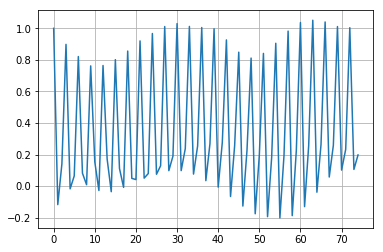

In [60]:
plt.plot(X.mean());
plt.grid(True);

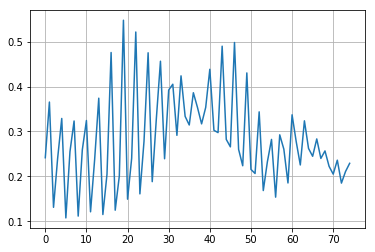

In [61]:
plt.plot(X.std());
plt.grid(True);

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [63]:
scaler = StandardScaler()
scaler.fit(X)
X0 = scaler.transform(X)

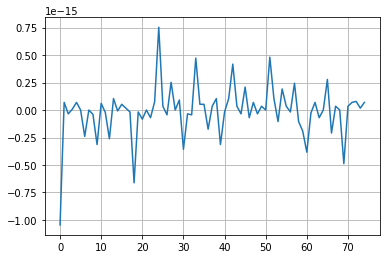

In [64]:
plt.plot(X0.mean(axis=0));
plt.grid(True);

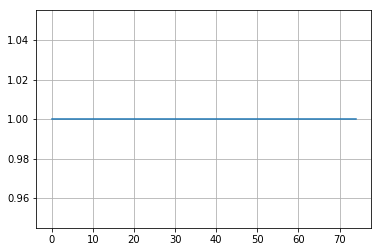

In [65]:
plt.plot(X0.std(axis=0));
plt.grid(True);

## Combine the scaler and a classifier

In [66]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC()),
])

In [61]:
model.fit(X,Y)
y_pred = model.predict(X)

In [62]:
labels=sorted(motionset.keys())
C = confusion_matrix(Y, y_pred, labels=labels)
C

array([[23,  0,  0,  0,  0,  0,  3,  0,  0,  0],
       [ 0, 15,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 12,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 19,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 15,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 38,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 16,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 22,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 22]])

In [63]:
y_pred_train = model.predict(X)
print(classification_report(Y, y_pred_train))

             precision    recall  f1-score   support

          0       1.00      0.88      0.94        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.93      1.00      0.96        38
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.99      0.99      0.99       204



### Assess the generalization capability by crossvalidation

In [64]:
from sklearn.model_selection import cross_validate

In [65]:
cv = cross_validate(model, X, Y, cv=10, return_train_score=False)
DataFrame(data=cv)

,fit_time,score_time,test_score
0,0.015124,0.002419,1.000000
1,0.014128,0.002492,0.960000
2,0.014425,0.002118,0.772727
3,0.034352,0.001977,1.000000
4,0.014383,0.002460,0.954545
5,0.015048,0.001925,1.000000
6,0.014643,0.001854,1.000000
7,0.014710,0.002351,0.944444
8,0.014649,0.001714,1.000000
9,0.015244,0.001802,1.000000


In [66]:
from sklearn.model_selection import cross_val_predict

In [67]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)

In [68]:
wrong = np.where(y_pred_cv != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred_cv[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,51,0,6
1,53,0,6
2,54,0,6
3,61,0,6
4,67,0,6
5,144,6,0
6,146,6,0
7,147,6,0


In [69]:
print(classification_report(Y, y_pred_cv))

             precision    recall  f1-score   support

          0       0.88      0.81      0.84        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.88      0.92      0.90        38
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.96      0.96      0.96       204



### Let's try to improve the classifier

In [70]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(kernel='rbf')),
])

In [71]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)
print(classification_report(Y, y_pred_cv))

             precision    recall  f1-score   support

          0       0.88      0.81      0.84        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.88      0.92      0.90        38
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.96      0.96      0.96       204



### Automatic meta parameter search

In [72]:
from sklearn.model_selection import GridSearchCV

In [73]:
gamma0 = 1.0 / (X.shape[1] * X.std().std())

svm_cv = GridSearchCV(
            estimator = SVC(kernel='rbf'),
            param_grid = [
                # variations with the RBF kernel
                dict(
                    kernel=['rbf'],
                    C=[1, 0.1, 0.01],
                    gamma=np.array([1/10, 1/5, 1/2, 1.0, 2, 4])*gamma0
                ),
                # variations with a linear kernel
                dict(
                    kernel=['linear'],
                    C=[1, 0.1, 0.01]
                )
            ],
            cv = 10,
            iid=True,
            verbose = 1
        )

model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', svm_cv),
])

In [74]:
model.fit(X,Y)

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.9s finished


Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', GridSearchCV(cv=10, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=Fal...   pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1))])

In [75]:
model.named_steps['svc'].best_params_ 

{'C': 1, 'kernel': 'linear'}

In [76]:
y_pred_cv = cross_val_predict(model, X, Y, cv=10)
print(classification_report(Y, y_pred_cv))

Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.5s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.5s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.0s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.0s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.5s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.5s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.0s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.2s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    5.2s finished


Fitting 10 folds for each of 21 candidates, totalling 210 fits
             precision    recall  f1-score   support

          0       0.85      0.88      0.87        26
          1       1.00      1.00      1.00        15
          2       1.00      1.00      1.00        12
          3       1.00      1.00      1.00        19
          4       1.00      1.00      1.00        19
          5       1.00      1.00      1.00        15
          6       0.92      0.89      0.91        38
          7       1.00      1.00      1.00        16
          8       1.00      1.00      1.00        22
          9       1.00      1.00      1.00        22

avg / total       0.97      0.97      0.97       204



[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    4.6s finished


In [77]:
wrong = np.where(y_pred_cv != Y)[0]
DataFrame(
    data=[[i, Y[i], y_pred_cv[i]] for i in wrong],
    columns=['Example', 'True', 'Predicted']
)

,Example,True,Predicted
0,51,0,6
1,53,0,6
2,54,0,6
3,146,6,0
4,147,6,0
5,156,6,0
6,173,6,0


# Train final model and deploy to Watson Machine Learning Model service

### Prerequisits

First one has to initialize a machine learning model service and ad credetials for this service

### Install and import machine learning client library and copy the credentials in a hidden cell

In [42]:
!pip install watson-machine-learning-client --upgrade

Requirement already up-to-date: watson-machine-learning-client in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages
Requirement not upgraded as not directly required: urllib3 in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: lomond in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: ibm-cos-sdk in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tqdm in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: tabulate in /opt/conda/envs/DSX-Python35/lib/python3.5/site-packages (from watson-machine-learning-client)
Requirement not upgraded as not directly required: requests in /opt/conda/envs/DSX-Python35

In [43]:
from watson_machine_learning_client import WatsonMachineLearningAPIClient

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [44]:
# The code was removed by Watson Studio for sharing.

### Instantiate a client

In [45]:
wml_client = WatsonMachineLearningAPIClient(wml_credentials)

In [46]:
import json

instance_details = wml_client.service_instance.get_details()
print(json.dumps(instance_details, indent=2))

{
  "entity": {
    "source": "Bluemix",
    "space_guid": "N/A",
    "published_models": {
      "url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/published_models"
    },
    "owner": {
      "country_code": "AUT",
      "ibm_id": "550001A6MU",
      "user_id": "bf820068-94e0-4832-aefa-614b29b9ef70",
      "beta_user": false,
      "email": "thomas.natschlaeger@gmail.com"
    },
    "deployments": {
      "url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments"
    },
    "organization_guid": "N/A",
    "usage": {
      "capacity_units": {
        "current": 3,
        "limit": 180000000
      },
      "deployment_count": {
        "current": 1,
        "limit": 5
      },
      "computation_time": {
        "current": 0,
        "limit": 180000
      },
      "gpu_count": {
        "current": 0,
        "limit": 8
      },
      "model_count": {
        "current": 1,
        "limit": 200
    

#### Build final model

In [67]:
final = model = Pipeline([
    ('scale', StandardScaler()),
    ('svc', SVC(kernel='rbf')),
])

y_pred_cv = cross_val_predict(final, X, Y, cv=10)
print(classification_report(Y, y_pred_cv))

final.fit(X,Y)

NameError: name 'cross_val_predict' is not defined

In [89]:
model_props = {
    wml_client.repository.ModelMetaNames.AUTHOR_NAME: "Thomas Natschläger", 
    wml_client.repository.ModelMetaNames.AUTHOR_EMAIL: "thomas.natschlaeger@gmail.com",
    wml_client.repository.ModelMetaNames.NAME: "Motion based digit classification"
}
model_props

{'authorName': 'Thomas Natschläger',
 'author_email': 'thomas.natschlaeger@gmail.com',
 'name': 'Motion based digit classification'}

#### Publishing the model

In [90]:
published_model = wml_client.repository.store_model(model=final, meta_props=model_props, training_data=X, training_target=Y)

In [92]:
wml_client.repository.list_models()

------------------------------------  -------------------------------------  ------------------------  -----------------
GUID                                  NAME                                   CREATED                   FRAMEWORK
e4288993-9a96-4c4e-8ba4-0b65fc729870  Motion based digit classification      2018-12-28T09:40:30.880Z  scikit-learn-0.19
7c68a2e1-3d3d-4abc-9155-6c083b7f112c  LOCALLY created IRIS prediction model  2018-11-11T12:44:10.059Z  scikit-learn-0.19
------------------------------------  -------------------------------------  ------------------------  -----------------


In [96]:
published_model_uid = wml_client.repository.get_model_uid(published_model)
model_details = wml_client.repository.get_details(published_model_uid)
print(json.dumps(model_details, indent=2))

{
  "metadata": {
    "created_at": "2018-12-28T09:40:30.880Z",
    "guid": "e4288993-9a96-4c4e-8ba4-0b65fc729870",
    "modified_at": "2018-12-28T09:40:30.918Z",
    "url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/published_models/e4288993-9a96-4c4e-8ba4-0b65fc729870"
  },
  "entity": {
    "model_type": "scikit-learn-0.19",
    "learning_configuration_url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/published_models/e4288993-9a96-4c4e-8ba4-0b65fc729870/learning_configuration",
    "feedback_url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/published_models/e4288993-9a96-4c4e-8ba4-0b65fc729870/feedback",
    "latest_version": {
      "created_at": "2018-12-28T09:40:30.918Z",
      "guid": "52da5890-4736-4308-ae45-481e9be07033",
      "url": "https://eu-de.ml.cloud.ibm.com/v3/ml_assets/models/e4288993-9a96-4c4e-8ba4-0b65fc729870/versions/52da5890-4736-4308-a

#### Creating a deployment (i.e. the callable WEB service)

In [98]:
created_deployment = wml_client.deployments.create(published_model_uid, "Deployment digit classifier")



#######################################################################################

Synchronous deployment creation for uid: 'e4288993-9a96-4c4e-8ba4-0b65fc729870' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='fc60458e-3394-49cf-bca2-848d5ea54a6b'
------------------------------------------------------------------------------------------------




In [99]:
print(json.dumps(created_deployment, indent=2))

{
  "metadata": {
    "created_at": "2018-12-28T09:44:28.640Z",
    "guid": "fc60458e-3394-49cf-bca2-848d5ea54a6b",
    "modified_at": "2018-12-28T09:44:29.477Z",
    "url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments/fc60458e-3394-49cf-bca2-848d5ea54a6b"
  },
  "entity": {
    "scoring_url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments/fc60458e-3394-49cf-bca2-848d5ea54a6b/online",
    "model_type": "scikit-learn-0.19",
    "name": "Deployment digit classifier",
    "description": "Description of deployment",
    "type": "online",
    "deployable_asset": {
      "created_at": "2018-12-28T09:44:28.622Z",
      "type": "model",
      "name": "Motion based digit classification",
      "guid": "e4288993-9a96-4c4e-8ba4-0b65fc729870",
      "url": "https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/published_models/e4288993-9a96-4c4e-8ba4-0b65fc729870"


# Use the deployed model via a WEB request

#### Get an access token to be able to use the deployment

In [104]:
import urllib3, requests, json

headers = urllib3.util.make_headers(basic_auth='{username}:{password}'.format(username=wml_credentials['username'], password=wml_credentials['password']))
url = '{}/v3/identity/token'.format(wml_credentials['url'])
response = requests.get(url, headers=headers)
mltoken = json.loads(response.text).get('token')

In [113]:
list(X.iloc[1,:])

[1.4886,
 0.3253,
 0.2381,
 1.1899303240740742,
 0.5506958333333333,
 0.062307407407407395,
 0.843248263888889,
 0.42604305555555555,
 0.06312465277777778,
 0.5064880208333333,
 0.17949635416666665,
 0.10436354166666667,
 0.3676756944444445,
 -0.16774652777777765,
 0.028868055555555563,
 0.3998979166666666,
 -0.4093052083333333,
 -0.025747743055555543,
 0.6318375,
 -0.52745625,
 -0.05598229166666666,
 0.800514157706093,
 -0.5332663082437276,
 -0.008548745519713297,
 0.9540722222222221,
 -0.4826152777777778,
 0.03202569444444446,
 1.1062750000000001,
 -0.31950625,
 -0.020203125000000002,
 1.1522770833333333,
 -0.18692013888888898,
 -0.006792361111111152,
 1.1153776041666668,
 -0.07816059027777794,
 0.0578574652777777,
 1.1103333333333334,
 0.12831770833333334,
 0.16181562500000002,
 1.1104511363636362,
 0.353268371212121,
 0.2541503787878788,
 1.1163999999999998,
 0.6035833333333329,
 0.30266666666666664,
 1.0752887096774193,
 0.5631419354838709,
 0.2974532258064516,
 1.0301536231884056

In [117]:
header = {'Content-Type': 'application/json', 'Authorization': 'Bearer ' + mltoken}

# NOTE: We simple send some train data
payload_scoring = {
    "fields": ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "13", "14", "15", "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31", "32", "33", "34", "35", "36", "37", "38", "39", "40", "41", "42", "43", "44", "45", "46", "47", "48", "49", "50", "51", "52", "53", "54", "55", "56", "57", "58", "59", "60", "61", "62", "63", "64", "65", "66", "67", "68", "69", "70", "71", "72", "73", "74"],
    "values": [
        list(X.iloc[1,:]),
        list(X.iloc[10,:]),
        list(X.iloc[100,:]),
    ]
}

response_scoring = requests.post('https://eu-de.ml.cloud.ibm.com/v3/wml_instances/c6cffbe7-484d-4ddc-ba18-11212d5417d8/deployments/fc60458e-3394-49cf-bca2-848d5ea54a6b/online', json=payload_scoring, headers=header)
print("Scoring response")
print(json.loads(response_scoring.text))

Scoring response
{'values': [['2'], ['2'], ['8']], 'fields': ['prediction']}


In [118]:
Y[1], Y[10], Y[100]

('2', '2', '8')

In [116]:

Y

0      2
1      2
2      2
3      2
4      2
5      2
6      2
7      2
8      2
9      2
10     2
11     2
12     7
13     7
14     7
15     7
16     7
17     7
18     7
19     7
20     7
21     7
22     7
23     7
24     7
25     7
26     7
27     7
28     4
29     4
      ..
174    1
175    1
176    1
177    1
178    1
179    1
180    1
181    1
182    1
183    1
184    1
185    1
186    1
187    1
188    1
189    5
190    5
191    5
192    5
193    5
194    5
195    5
196    5
197    5
198    5
199    5
200    5
201    5
202    5
203    5
Length: 204, dtype: object